# Football in Denmark: Where are we playing?

Imports and set magics:

In [1]:
# %pip install git+https://github.com/alemartinello/dstapi #Installing the API (only need to do once)

In [2]:
# %pip install pandas-datareader # Installing the data reader (only need to do once)

In [3]:
# %pip install geopandas # Installing the geopandas reader (only need to do once)

In [4]:
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
import ipywidgets as widgets
# from matplotlib_venn import venn2
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read and clean data

Creating a dictionary for the columns names:

In [5]:
columns_dict = {}
columns_dict['BLSTKOM'] = 'county'
columns_dict['AKTIVITET'] = 'activity'
columns_dict['KON'] = 'sex'
columns_dict['ALDER1'] = 'age'
columns_dict['TID'] = 'year'
columns_dict['INDHOLD'] = 'value'

#var_dict = {} # var is for variable
#var_dict['Football'] = 'football'

**Step 1:** Downloading all of the football-variables in IDRAKT01

In [6]:
idrakt_api = DstApi('IDRAKT01')  #Creating the DST API which will allow us to interact with the API server
params = idrakt_api._define_base_params(language='en') #Creating a parameter dictionary with the language set to English
variables = params['variables'] # Returns a view, that we can edit
variables[1]['values'] = ['A22'] # Choosing football as the activity (The ID for football is A22 Using code from: https://alemartinello.com/2022/02/24/dstapi/)
print(variables)

[{'code': 'BLSTKOM', 'values': ['*']}, {'code': 'AKTIVITET', 'values': ['A22']}, {'code': 'KON', 'values': ['*']}, {'code': 'ALDER1', 'values': ['*']}, {'code': 'Tid', 'values': ['*']}]


In [7]:
idrakt = idrakt_api.get_data(params=params) #Downloading the dataset

In [8]:
idrakt.head() #Looking at the dataset

,BLSTKOM,AKTIVITET,KON,ALDER1,TID,INDHOLD
0,Herning,Football,Men,"Age, total",2017,4950
1,Herning,Football,Men,0-12 years,2017,1850
2,Herning,Football,Men,13-18 years,2017,1070
3,Herning,Football,Men,19-24 years,2017,660
4,Herning,Football,Men,25-59 years,2017,1250


**Step 2:** Rename coloums using colmns_dict

In [9]:
idrakt.rename(columns=columns_dict,inplace=True)
idrakt.head()

,county,activity,sex,age,year,value
0,Herning,Football,Men,"Age, total",2017,4950
1,Herning,Football,Men,0-12 years,2017,1850
2,Herning,Football,Men,13-18 years,2017,1070
3,Herning,Football,Men,19-24 years,2017,660
4,Herning,Football,Men,25-59 years,2017,1250


**Step 3:** Only keep rows where the variable is in `Age, total` and afterwards deleting the coloumn.

In [10]:
#Only keeps rows with age = 'Age, total' and afterwards deleting the age coloumn
idrakt = idrakt[idrakt['age'] == 'Age, total']
idrakt.drop(columns=['age'],inplace=True)
idrakt.head()

,county,activity,sex,year,value
0,Herning,Football,Men,2017,4950
6,Herning,Football,"Sex, total",2017,6240
12,Herning,Football,Women,2017,1290
18,Horsens,Football,Men,2017,4580
24,Horsens,Football,"Sex, total",2017,6240


**Step 4:** Only keep rows where the variable is in a region or total

In [11]:
# Keeping rows where 'county' starts with "Landsdel" or is "All Denmark"
idrakt = idrakt[idrakt['county'].str.startswith('Province') | (idrakt['county'] == 'All Denmark')]
idrakt.head()

,county,activity,sex,year,value
180,Province Nordjylland,Football,Men,2019,30800
186,Province Nordjylland,Football,"Sex, total",2019,40140
192,Province Nordjylland,Football,Women,2019,9340
288,Province Byen København,Football,Men,2017,43840
294,Province Byen København,Football,"Sex, total",2017,49680


**Step 5:** Sort the dataset by county, year and sex

In [12]:
# Sorting the dataset by county then year and then total sex, but first we customly sort the order of Sex
# Define a custom sorting order
sort_order = ['Sex, total', 'Men', 'Women']

# Create a categorical type with the custom order
idrakt['sex'] = pd.Categorical(idrakt['sex'], categories=sort_order, ordered=True)

idrakt.sort_values(by=['county','year','sex'],inplace=True)
idrakt.reset_index(drop=True,inplace=True)
idrakt.head()

,county,activity,sex,year,value
0,All Denmark,Football,"Sex, total",2014,374400
1,All Denmark,Football,Men,2014,307430
2,All Denmark,Football,Women,2014,66970
3,All Denmark,Football,"Sex, total",2015,372640
4,All Denmark,Football,Men,2015,306540


In [13]:
# create a new column named 'county_B' with the a broader definition of the counties. If county is All Denmark, then county_B is All Denmark.
# county_B is split into Jylland, Sjælland and Fyn.
# Therefore I sum the values of the counties in Jylland, Sjælland and Fyn to get the values of the broader definition of the counties.
# Here Jylland is the counties: 'Province Nordjylland', 'Province Sydjylland', 'Province Vestjylland', 'Province Østjylland'
# Sjælland is the counties: 'Province Bornholm', 'Province Københavns omegn', 'Province Byen København', 'Province Nordsjælland', 'Province Østsjælland', 'Province Vest- og Sydsjælland'
# Fyn is the counties: 'Province Fyn'

# Define a function to map each county to its broader definition
# Define a function to map each county to its broader definition
def map_county_b(county):
    if county == 'All Denmark':
        return 'All Denmark'
    if county in ['Province Nordjylland', 'Province Sydjylland', 'Province Vestjylland', 'Province Østjylland']:
        return 'Jylland'
    elif county in ['Province Bornholm', 'Province Københavns omegn', 'Province Byen København', 'Province Nordsjælland', 'Province Østsjælland', 'Province Vest- og Sydsjælland']:
        return 'Sjælland'
    elif county == 'Province Fyn':
        return 'Fyn'

# Apply the function to create the new variable 'county_b'
idrakt['county_b'] = idrakt['county'].apply(map_county_b)

# Print the first few rows to verify the new variable
idrakt.head()


,county,activity,sex,year,value,county_b
0,All Denmark,Football,"Sex, total",2014,374400,All Denmark
1,All Denmark,Football,Men,2014,307430,All Denmark
2,All Denmark,Football,Women,2014,66970,All Denmark
3,All Denmark,Football,"Sex, total",2015,372640,All Denmark
4,All Denmark,Football,Men,2015,306540,All Denmark


In [14]:
# Creating a copy of the dataset where we only keep the rows with the value 'All Denmark' in the 'county' column
idrakt_all = idrakt[idrakt['county'] == 'All Denmark'].copy()
idrakt_all.drop(columns=['county'],inplace=True)
idrakt_all.head()

,activity,sex,year,value,county_b
0,Football,"Sex, total",2014,374400,All Denmark
1,Football,Men,2014,307430,All Denmark
2,Football,Women,2014,66970,All Denmark
3,Football,"Sex, total",2015,372640,All Denmark
4,Football,Men,2015,306540,All Denmark


In [15]:
# Sorting the total dataset by year
idrakt_all.sort_values(by='year',inplace=True)
idrakt_all.head()

,activity,sex,year,value,county_b
0,Football,"Sex, total",2014,374400,All Denmark
1,Football,Men,2014,307430,All Denmark
2,Football,Women,2014,66970,All Denmark
3,Football,"Sex, total",2015,372640,All Denmark
4,Football,Men,2015,306540,All Denmark


# Analysis across genders

Here we calculate the total number of Danish football players split based on sex. 

/var/folders/z8/1crkytq93gz7b66n_5673q3r0000gn/T/ipykernel_30454/4155998998.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_idrakt_stackedbar = idrakt_stackedbar.groupby(['year', 'sex'])['value'].sum().unstack()


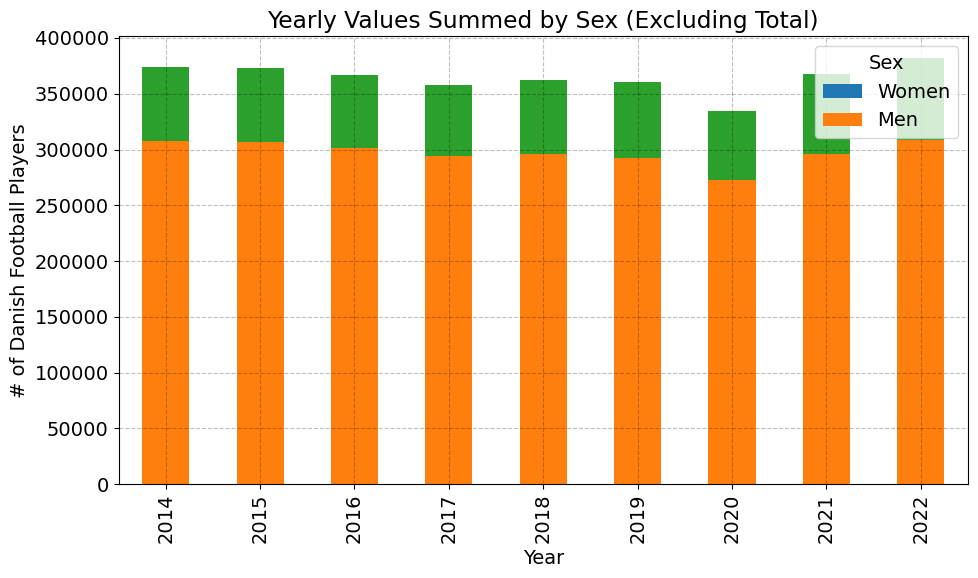

In [16]:
# Filtering out 'Sex, total' from the dataset
idrakt_stackedbar = idrakt_all[idrakt_all['sex'] != 'Sex, total']

# Grouping by 'year' and 'sex', then summing the values
grouped_idrakt_stackedbar = idrakt_stackedbar.groupby(['year', 'sex'])['value'].sum().unstack()

# Plotting the stacked bar chart
grouped_idrakt_stackedbar.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Yearly Values Summed by Sex (Excluding Total)')
plt.xlabel('Year')
plt.ylabel('# of Danish Football Players')
plt.legend(labels=['Women', 'Men'], title='Sex')
plt.tight_layout()
plt.show()

It is hard to see the relative development between the sexes and for total. Hence, we index the values and display here.

/var/folders/z8/1crkytq93gz7b66n_5673q3r0000gn/T/ipykernel_30454/1248261077.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for sex, group in indexed_idrakt_all.groupby('sex'): # Loop over the groups


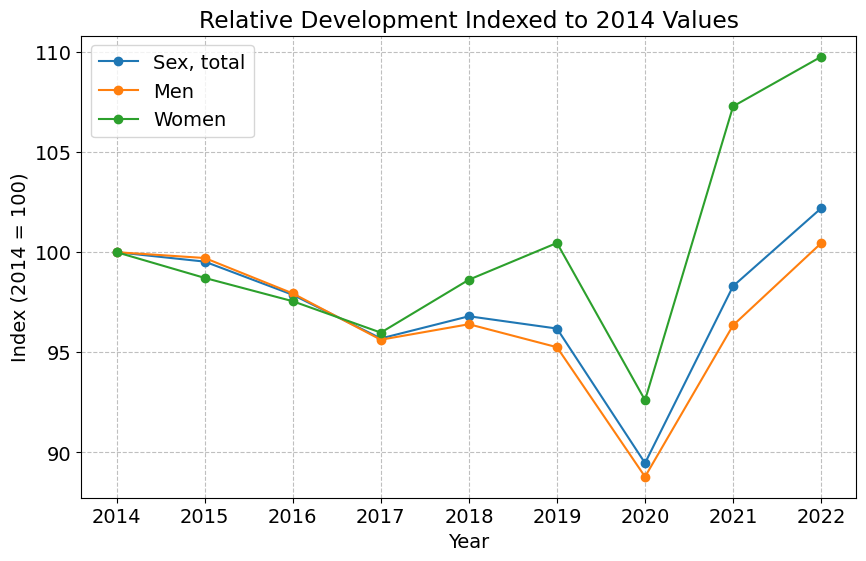

In [17]:
index_values = idrakt_all[idrakt_all['year'] == 2014].set_index('sex')['value'] # Create a series with the 2014 values
indexed_idrakt_all = idrakt_all.set_index(['year', 'sex']) # Set the index
indexed_idrakt_all['indexed_value'] = 100*indexed_idrakt_all['value'] / indexed_idrakt_all['value'].unstack().loc[2014] # Calculate the indexed values

# Resetting index for plotting
indexed_idrakt_all = indexed_idrakt_all.reset_index() 

# Step 2: Plot the indexed values
plt.figure(figsize=(10, 6))
for sex, group in indexed_idrakt_all.groupby('sex'): # Loop over the groups
    plt.plot(group['year'], group['indexed_value'], marker='o', label=sex) 

plt.title('Relative Development Indexed to 2014 Values')
plt.xlabel('Year')
plt.ylabel('Index (2014 = 100)')
plt.legend()
plt.grid(True)
plt.show()

2018 women suddenly increases a lot towards 2019. The lockdown in 2020 is visuably for both sexes. However, afterwards, women footballers continues to increase with a much higher rate than men.

Annual growth contributions

/var/folders/z8/1crkytq93gz7b66n_5673q3r0000gn/T/ipykernel_30454/2839459140.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idrakt_all['year_over_year_change'] = idrakt_all.groupby('sex')['value'].diff()


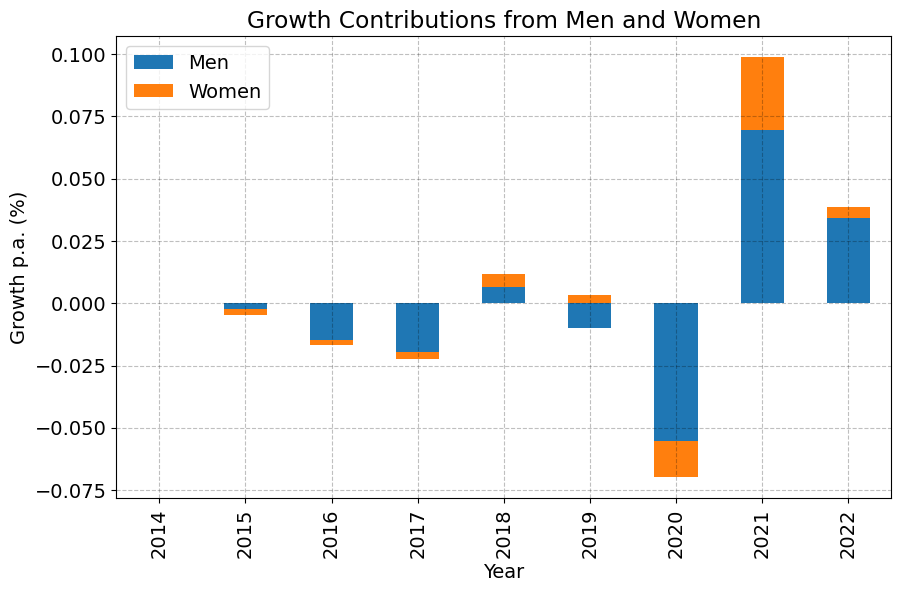

In [18]:
# Step 1: Calculate year-over-year change for each category
idrakt_all['year_over_year_change'] = idrakt_all.groupby('sex')['value'].diff()

# Step 2: Calculate the contribution for each category
# First, create a pivot for the total values to align with the changes data
total_values_previous_year = idrakt_all[idrakt_all['sex'] == 'Sex, total'][['year', 'value']].rename(columns={'value': 'total_previous_year'})
total_values_previous_year['year'] += 1  # Aligning total of year n-1 with year n

# Merge this back into the main DataFrame
idrakt_all = pd.merge(idrakt_all, total_values_previous_year, on='year', how='left')

# Now calculate the contributions
idrakt_all['contribution'] = idrakt_all.apply(lambda x: x['year_over_year_change'] / x['total_previous_year'] if x['sex'] != 'Sex, total' else None, axis=1)

# Step 3: Pivot the data for plotting
pivot_contribution = idrakt_all.pivot(index='year', columns='sex', values='contribution')

# Visualize the contributions
pivot_contribution[['Men', 'Women']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Growth Contributions from Men and Women')
plt.xlabel('Year')
plt.ylabel('Growth p.a. (%)')
plt.legend(['Men', 'Women'])
plt.show()

The figure above shows that even though women increases a lot, the contributions to the overall growth is fairly dominated by men because of the larger base. 

# Analysis across geography

Plotting the number of football players by county

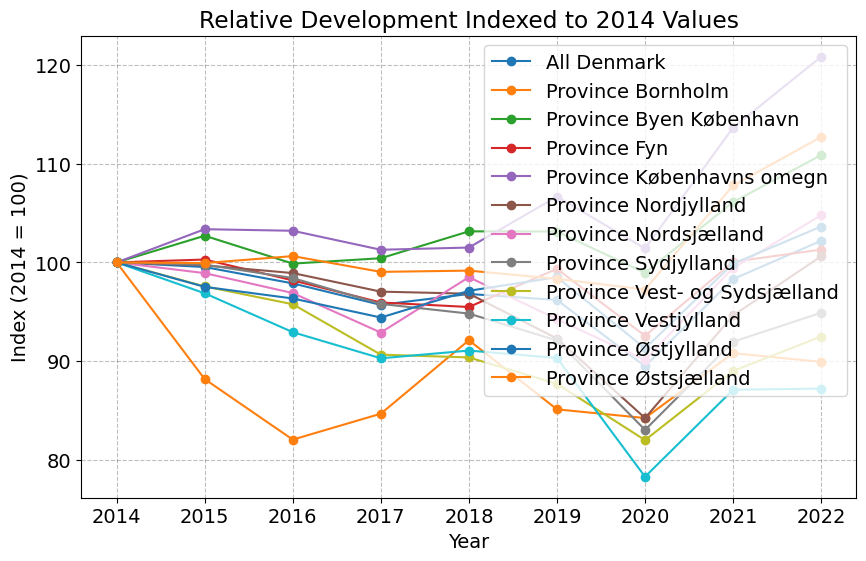

In [19]:
# Filter the DataFrame for 'Sex, total'
idrakt_sex_total = idrakt[idrakt['sex'] == 'Sex, total']

# Create a series with the 2014 values
index_values = idrakt_sex_total[idrakt_sex_total['year'] == 2014].set_index('county')['value']

# Set the index
indexed_idrakt = idrakt_sex_total.set_index(['year', 'county'])

# Calculate the indexed values
indexed_idrakt['indexed_value'] = 100*indexed_idrakt['value'] / indexed_idrakt['value'].unstack().loc[2014]

# Resetting index for plotting
indexed_idrakt = indexed_idrakt.reset_index()

# Plot the indexed values
plt.figure(figsize=(10, 6))
for county, group in indexed_idrakt.groupby('county'): # Loop over the groups
    plt.plot(group['year'], group['indexed_value'], marker='o', label=county)

plt.title('Relative Development Indexed to 2014 Values')
plt.xlabel('Year')
plt.ylabel('Index (2014 = 100)')
plt.legend()
plt.grid(True)
plt.show()

Because it is difficult to see what is going on, we make a plot, splitting into the broader county definition, county_b

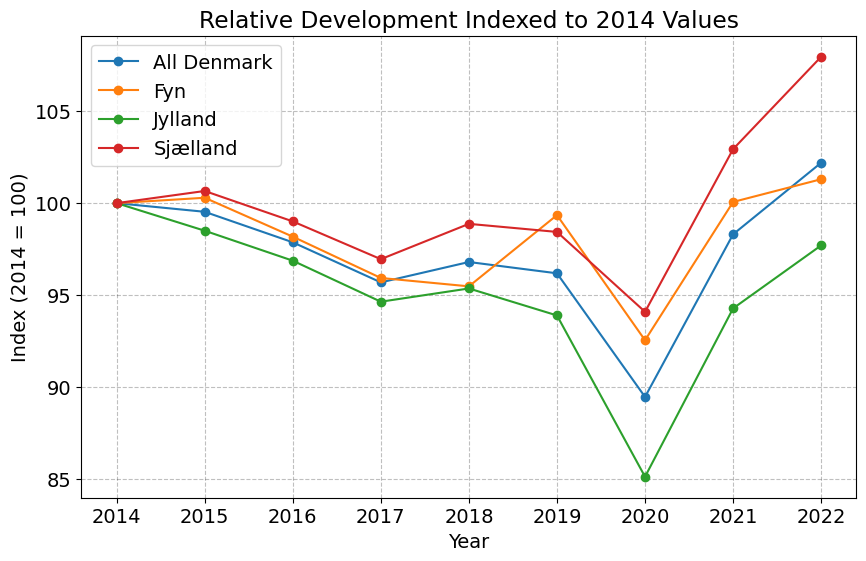

In [20]:
# Filter the DataFrame for 'Sex, total'
idrakt_sex_total_2 = idrakt[idrakt['sex'] == 'Sex, total']

# Pivot the DataFrame
pivot_table = idrakt_sex_total_2.pivot_table(index='year', columns='county_b', values='value', aggfunc='sum')

# Calculate indexed values relative to 2014
indexed_values = pivot_table.div(pivot_table.loc[2014]) * 100

# Plot the indexed values
plt.figure(figsize=(10, 6))
for county_b in indexed_values.columns:
    plt.plot(indexed_values.index, indexed_values[county_b], marker='o', label=county_b)

plt.title('Relative Development Indexed to 2014 Values')
plt.xlabel('Year')
plt.ylabel('Index (2014 = 100)')
plt.legend()
plt.grid(True)
plt.show()


Making a plot of the sexes across counties

# Conclusion

ADD CONCISE CONLUSION.

We see that...